In [6]:
import os
workdir = "/Users/kanxu/ASU Dropbox/Kan Xu/RL ISR Revision/Code/OnlineDQN"
#workdir = "/home/kanxu1/OnlineDQN"
os.chdir(workdir)

# data_preprocessing

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm.auto import tqdm
import random
import warnings

warnings.filterwarnings("ignore")


data = pd.read_csv("Data/20240205fullsample_new.csv")

data["installment_timestep"] = data.groupby(["loan_id", "installment"]).cumcount() + 1

states = [
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
]
# print('# of states ', len(states))

data[states] = (data[states] - data[states].mean()) / data[states].std()
# print(data.head())
# pdb.set_trace()

train = data.loc[(data["sample"] == "rlsimulator") & (data["group"] == "train")]
test = data.loc[(data["sample"] == "rlsimulator") & (data["group"] == "test")]

data_list = [train, test]
data_name_list = ["train", "test"]

varstate_size = 7

for j in tqdm(range(len(data_list)), leave=True):
    dt = data_list[j]
    dt_loan_ids = dt["loan_id"].drop_duplicates().tolist()

    X_df = pd.DataFrame()
    y_df = pd.DataFrame()

    for loan_id in tqdm(dt_loan_ids, leave=True):
        df1 = dt.loc[dt["loan_id"] == loan_id]

        X_train = df1[
            ["loan_id"]
            + states
            + [
                "action_num_actual",
                "installment_done",
                "loan_done",
                "recovery_rate_weighted",
            ]
        ]
        # X_train = X_train[:-1]
        X_df = X_df.append(X_train, ignore_index=True)

        y_train = df1[states[:varstate_size]]
        y_train = y_train.rename(
            columns={
                "installment": "installment.1",
                "installment_timestep": "installment_timestep.1",
                "state_cum_overduelength": "state_cum_overduelength.1",
                "remaining_debt": "remaining_debt.1",
                "state_capital": "state_capital.1",
                "state_interests": "state_interests.1",
                "state_penalty": "state_penalty.1",
            }
        )

        if y_train.shape[0] > 1:
            y_train = y_train[1:]
            y_train = y_train.append(y_train.iloc[-1], ignore_index=True)

        y_df = y_df.append(y_train, ignore_index=True)

    cols = (
        ["loan_id"]
        + states
        + ["action_num_actual"]
        + [
            "installment.1",
            "installment_timestep.1",
            "state_cum_overduelength.1",
            "remaining_debt.1",
            "state_capital.1",
            "state_interests.1",
            "state_penalty.1",
        ]
        + ["installment_done", "loan_done", "recovery_rate_weighted"]
    )
    result = pd.concat([X_df, y_df], axis=1)[cols]
    # print('result shape ', result.shape)

    ids = np.unique(result["loan_id"])
    for i in tqdm(range(len(ids)), leave=True):
        result.loc[result["loan_id"] == ids[i], "loan_id"] = i

    result["loan_id"] = [int(x) for x in result["loan_id"]]

    result.to_csv("Simulator/simulator_" + data_name_list[j] + "_data.csv", index=False)

    ##normalization
    # Compile the loans into batches
    batch_data = {}
    ids = np.unique(result["loan_id"])
    normalized = result.values

    for i in tqdm(range(len(ids)), leave=True):
        id_i = ids[i]
        batch_data[i] = normalized[normalized[:, 0] == id_i]

    output = open("Simulator/simulator_" + data_name_list[j] + "_batch.pkl", "wb")
    pickle.dump(batch_data, output)
    output.close()
    # pdb.set_trace()

ids = result["loan_id"].drop_duplicates().tolist()
k = int(0.1 * len(ids))  # 10% validation data

random.seed(
    42
)  # the current train and valid data are sampled without setting the random seed. if we run this later, we may get different dataset.
valid_ids = random.sample(ids, k)
train_ids = [elem for elem in ids if elem not in valid_ids]

train_data = result.loc[result["loan_id"].isin(train_ids)]
valid_data = result.loc[result["loan_id"].isin(valid_ids)]
valid_data.to_csv("Simulator/simulator_training_valid_batch.csv", index=False)
# pdb.set_trace()

batch_data = {}
normalized = train_data.values

for i in tqdm(range(len(train_ids)), leave=True):
    id_i = train_ids[i]
    batch_data[i] = normalized[normalized[:, 0] == id_i]


output = open("Simulator/simulator_training_train_batch.pkl", "wb")
pickle.dump(batch_data, output)
output.close()

# batch_data = {}
# normalized = valid_data.values

# for i in range(len(valid_ids)):
#    id_i = valid_ids[i]
#    batch_data[i] = normalized[normalized[:,0]==id_i]


# output = open('simulator_training_valid_batch.pkl', 'wb')
# pickle.dump(batch_data, output)
# output.close()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12528 [00:00<?, ?it/s]

  0%|          | 0/12528 [00:00<?, ?it/s]

  0%|          | 0/12528 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

# multitask_simulator_training

RNN:   0%|          | 0/100 [00:00<?, ?it/s]

0 0 0.6433037519454956
0 100 0.33197084069252014
1 0 0.23644550144672394
1 100 0.17210131883621216
2 0 0.1518736630678177
2 100 0.13667215406894684
3 0 0.11601242423057556
3 100 0.115101657807827
4 0 0.10604681819677353
4 100 0.10660416632890701
5 0 0.09490549564361572
5 100 0.09694990515708923
6 0 0.08232943713665009
6 100 0.08537191897630692
7 0 0.08253985643386841
7 100 0.07539832592010498
8 0 0.08672083169221878
8 100 0.06465911865234375
9 0 0.09795074164867401
9 100 0.0784422978758812
10 0 0.06772008538246155
10 100 0.07357862591743469
11 0 0.07137218862771988
11 100 0.07335922867059708
12 0 0.05916495621204376
12 100 0.07763253152370453
13 0 0.056970421224832535
13 100 0.0661550983786583
14 0 0.06706055253744125
14 100 0.06852921843528748
15 0 0.07592824101448059
15 100 0.06351123750209808
16 0 0.058622732758522034
16 100 0.07124805450439453
17 0 0.06121391803026199
17 100 0.06641845405101776
18 0 0.06707137823104858
18 100 0.04851899668574333
19 0 0.058172471821308136
19 100 0.0

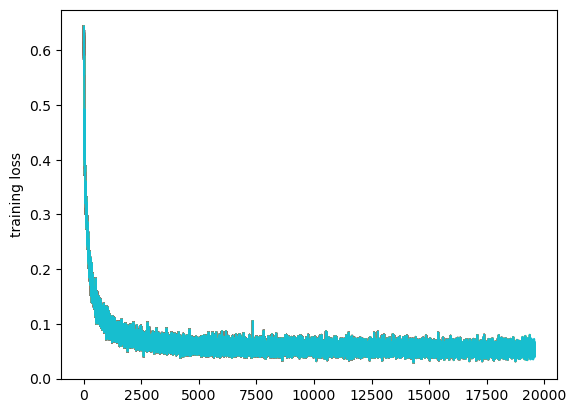

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from padsequence import *
from customized_dataloader import *
from multitask_lstm import *
from multitask_gru import *
from multitask_rnn import *
from masked_mse import *
from tqdm.auto import tqdm


# parser = ArgumentParser()
# parser.add_argument('--input_size',"-is", type=int, required=True)
# parser.add_argument('--lr', '-l', type=float, required=True)
# parser.add_argument('--batch_size', '-bs', type=int, required=True)
# parser.add_argument('--hidden_size', '-hs', type=int, required=True)
# parser.add_argument('--alpha', '-a', type=float, required=True)
# parser.add_argument('--epoch', '-e', type=int, required=True)
# parser.add_argument('--training_data_path', '-dp', type=str, required=True)
# parser.add_argument('--which_model', '-wm', type=str, required=True)

"""
	- input_size: the input size of the simulator
	- lr : The learning rate
	- batch_size : The size of the batch when sample from memory experience
	- hidden_size : the hidden size of the LSTM/GRU/RNN
	- alpha: the coefficient of the state prediction task for multitask training
	- epoch: number of training epochs
	- training_data_path: training data absolute path
    -- which_model: select the base model, options are 'LSTM', 'GRU', 'RNN'

"""


# args = parser.parse_args()

data_path = "Simulator/simulator_train_batch.pkl"  # args.training_data_path
pkl_file = open(data_path, "rb")
train_batch_data = pickle.load(pkl_file)
pkl_file.close()

ds = Mydataset(train_batch_data)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_see·d(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 21  # args.input_size
LR = 0.001  # args.lr
batch_size = 64  # args.batch_size
hidden_size = 50  # args.hidden_size
alpha = 0.25  # args.alpha
epochs = 100  # args.epoch
which_model = "RNN"  # args.which_model

train_loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=PadSequence(),
    num_workers=2,
)

varstate_size = 7
model_zoo = {
    "LSTM": MultitaskLSTM(
        input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size
    ),
    "GRU": MultitaskGRU(
        input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size
    ),
    "RNN": MultitaskRNN(
        input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size
    ),
}

model = model_zoo[which_model]

optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = MaskedMSE()
loss_func_bc = MaskedBCE()
# print (model)


h_state = None
train_loss_record = []


for epoch in tqdm(range(epochs), desc=which_model):
    for step, (b_x, lenghts, b_y) in enumerate(train_loader):
        (
            state_prediction,
            installment_done_prediction,
            loan_done_prediction,
            reward_prediction,
            _,
        ) = model(b_x, lenghts, h_state)

        state_mask = torch.zeros(state_prediction.size())
        installment_done_mask = torch.zeros(installment_done_prediction.size())
        loan_done_mask = torch.zeros(loan_done_prediction.size())
        reward_mask = torch.zeros(reward_prediction.size())

        for batch_id, item in enumerate(lenghts):
            state_mask[batch_id][:item] = 1
            installment_done_mask[batch_id][:item] = 1
            loan_done_mask[batch_id][:item] = 1
            reward_mask[batch_id][:item] = 1

        # state_mask = state_mask.type(torch.uint8)
        state_mask = state_mask.bool()
        installment_done_mask = installment_done_mask.bool()
        loan_done_mask = loan_done_mask.bool()
        # reward_mask = reward_mask.type(torch.uint8)
        reward_mask = reward_mask.bool()

        state_loss = loss_func(
            state_prediction, b_y[:, :, :varstate_size], state_mask
        )  # calculate loss
        installment_done_loss = loss_func_bc(
            installment_done_prediction,
            b_y[:, :, -3].unsqueeze(2),
            installment_done_mask,
        )
        loan_done_loss = loss_func_bc(
            loan_done_prediction, b_y[:, :, -2].unsqueeze(2), loan_done_mask
        )
        reward_loss = loss_func(
            reward_prediction, b_y[:, :, -1].unsqueeze(2), reward_mask
        )

        # multi-task loss controlled by the factor alpha
        # loss = alpha * state_loss + (1-alpha) * reward_loss
        loss = (
            alpha * state_loss
            + alpha * reward_loss
            + alpha * installment_done_loss
            + (1 - 3 * alpha) * loan_done_loss
        )

        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()

        train_loss_record.append(loss.item())

        if step % 100 == 0:
            print(epoch, step, loss.item())

    torch.save(
        model,
        "Simulator/generated_multitask_"
        + which_model
        + "_simulator_"
        + str(LR)
        + "_"
        + str(batch_size)
        + ".pkl",
    )

    plt.plot(train_loss_record)
    plt.ylabel("training loss")
    # plt.show()
    plt.savefig(
        "Simulator/Figure/training_loss_"
        + which_model
        + "_"
        + str(LR)
        + "_"
        + str(batch_size)
        + ".png"
    )

GRU:   0%|          | 0/100 [00:00<?, ?it/s]

0 0 0.636699914932251
0 100 0.341951847076416
1 0 0.2579280436038971
1 100 0.1693500131368637
2 0 0.14309628307819366
2 100 0.12318755686283112
3 0 0.10170004516839981
3 100 0.10321612656116486
4 0 0.08854853361845016
4 100 0.08833863586187363
5 0 0.07888756692409515
5 100 0.07752453535795212
6 0 0.0652746632695198
6 100 0.069095678627491
7 0 0.06125786527991295
7 100 0.059583649039268494
8 0 0.0697714239358902
8 100 0.05069471895694733
9 0 0.08138597756624222
9 100 0.06410061568021774
10 0 0.05386894941329956
10 100 0.0617075152695179
11 0 0.06061246991157532
11 100 0.06173998489975929
12 0 0.049368564039468765
12 100 0.0669785588979721
13 0 0.04836789146065712
13 100 0.057593934237957
14 0 0.060414377599954605
14 100 0.06065548211336136
15 0 0.06581158190965652
15 100 0.05890020728111267
16 0 0.04894182085990906
16 100 0.06337951123714447
17 0 0.05306579917669296
17 100 0.0602986216545105
18 0 0.05888810753822327
18 100 0.04355047643184662
19 0 0.051882319152355194
19 100 0.049343615

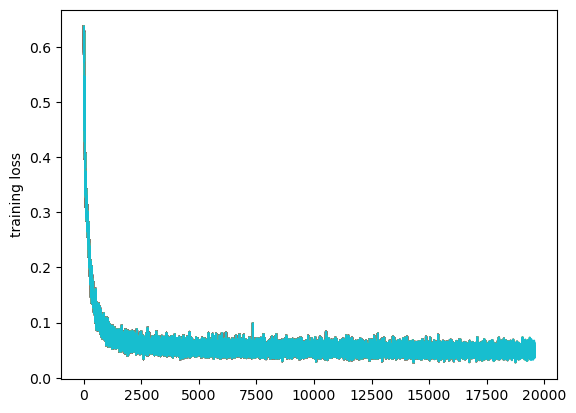

In [11]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence 
from padsequence import *
from customized_dataloader import *
from multitask_lstm import *
from multitask_gru import *
from multitask_rnn import *
from masked_mse import *
from tqdm.auto import tqdm





#parser = ArgumentParser()
#parser.add_argument('--input_size',"-is", type=int, required=True)
#parser.add_argument('--lr', '-l', type=float, required=True)
#parser.add_argument('--batch_size', '-bs', type=int, required=True)
#parser.add_argument('--hidden_size', '-hs', type=int, required=True)
#parser.add_argument('--alpha', '-a', type=float, required=True)
#parser.add_argument('--epoch', '-e', type=int, required=True)
#parser.add_argument('--training_data_path', '-dp', type=str, required=True)
#parser.add_argument('--which_model', '-wm', type=str, required=True)

'''
	- input_size: the input size of the simulator
	- lr : The learning rate
	- batch_size : The size of the batch when sample from memory experience
	- hidden_size : the hidden size of the LSTM/GRU/RNN
	- alpha: the coefficient of the state prediction task for multitask training
	- epoch: number of training epochs
	- training_data_path: training data absolute path
    -- which_model: select the base model, options are 'LSTM', 'GRU', 'RNN'

'''


#args = parser.parse_args()

data_path = 'Simulator/simulator_train_batch.pkl' #args.training_data_path
pkl_file = open(data_path, 'rb')
train_batch_data = pickle.load(pkl_file)
pkl_file.close()

ds = Mydataset(train_batch_data)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 21 #args.input_size
LR = 0.001 #args.lr     
batch_size = 64 #args.batch_size
hidden_size = 50 #args.hidden_size
alpha = 0.25 #args.alpha
epochs = 100 #args.epoch
which_model = 'GRU' #args.which_model

train_loader =DataLoader(
    dataset = ds,
    batch_size = batch_size,
    shuffle = True,
    collate_fn=PadSequence(),
    num_workers = 2)

varstate_size = 7
model_zoo = {'LSTM': MultitaskLSTM(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size),
             'GRU': MultitaskGRU(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size),
             'RNN': MultitaskRNN(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size)}

model = model_zoo[which_model]

optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = MaskedMSE()
loss_func_bc = MaskedBCE()
#print (model)


h_state = None
train_loss_record = []


for epoch in tqdm(range(epochs), desc=which_model):
    for step, (b_x, lenghts, b_y) in enumerate(train_loader): 
        state_prediction, installment_done_prediction, loan_done_prediction, reward_prediction, _ = model(b_x, lenghts,h_state)   
        
        state_mask = torch.zeros(state_prediction.size())
        installment_done_mask = torch.zeros(installment_done_prediction.size())
        loan_done_mask = torch.zeros(loan_done_prediction.size())
        reward_mask = torch.zeros(reward_prediction.size())

        for batch_id, item in enumerate(lenghts):
            state_mask[batch_id][:item]=1
            installment_done_mask[batch_id][:item]=1
            loan_done_mask[batch_id][:item]=1
            reward_mask[batch_id][:item]=1

        # state_mask = state_mask.type(torch.uint8)
        state_mask = state_mask.bool()
        installment_done_mask = installment_done_mask.bool()
        loan_done_mask = loan_done_mask.bool()
        # reward_mask = reward_mask.type(torch.uint8)
        reward_mask = reward_mask.bool()

        state_loss = loss_func(state_prediction, b_y[:,:,:varstate_size],state_mask )         # calculate loss
        installment_done_loss = loss_func_bc(installment_done_prediction, b_y[:,:,-3].unsqueeze(2), installment_done_mask)
        loan_done_loss = loss_func_bc(loan_done_prediction, b_y[:,:,-2].unsqueeze(2), loan_done_mask)
        reward_loss = loss_func(reward_prediction, b_y[:,:,-1].unsqueeze(2),reward_mask)

        #multi-task loss controlled by the factor alpha
        # loss = alpha * state_loss + (1-alpha) * reward_loss
        loss = alpha * state_loss + alpha * reward_loss + alpha * installment_done_loss + (1 - 3 * alpha) * loan_done_loss 

        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step() 

        train_loss_record.append(loss.item())

        if step % 100 ==0:
            print (epoch, step, loss.item())
                
    
    torch.save(model, 'Simulator/generated_multitask_'+which_model+'_simulator_'+str(LR)+'_'+str(batch_size)+'.pkl')

    plt.plot(train_loss_record)
    plt.ylabel('training loss')
    #plt.show()
    plt.savefig('Simulator/Figure/training_loss_'+which_model+'_'+str(LR)+'_'+str(batch_size)+'.png')

In [1]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence 
from padsequence import *
from customized_dataloader import *
from multitask_lstm import *
from multitask_gru import *
from multitask_rnn import *
from masked_mse import *
from tqdm.auto import tqdm





#parser = ArgumentParser()
#parser.add_argument('--input_size',"-is", type=int, required=True)
#parser.add_argument('--lr', '-l', type=float, required=True)
#parser.add_argument('--batch_size', '-bs', type=int, required=True)
#parser.add_argument('--hidden_size', '-hs', type=int, required=True)
#parser.add_argument('--alpha', '-a', type=float, required=True)
#parser.add_argument('--epoch', '-e', type=int, required=True)
#parser.add_argument('--training_data_path', '-dp', type=str, required=True)
#parser.add_argument('--which_model', '-wm', type=str, required=True)

'''
	- input_size: the input size of the simulator
	- lr : The learning rate
	- batch_size : The size of the batch when sample from memory experience
	- hidden_size : the hidden size of the LSTM/GRU/RNN
	- alpha: the coefficient of the state prediction task for multitask training
	- epoch: number of training epochs
	- training_data_path: training data absolute path
    -- which_model: select the base model, options are 'LSTM', 'GRU', 'RNN'

'''


#args = parser.parse_args()

data_path = 'Simulator/simulator_train_batch.pkl' #args.training_data_path
pkl_file = open(data_path, 'rb')
train_batch_data = pickle.load(pkl_file)
pkl_file.close()

ds = Mydataset(train_batch_data)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 21 #args.input_size
LR = 0.001 #args.lr     
batch_size = 64 #args.batch_size
hidden_size = 50 #args.hidden_size
alpha = 0.25 #args.alpha
epochs = 100 #args.epoch
which_model = 'LSTM' #args.which_model

train_loader =DataLoader(
    dataset = ds,
    batch_size = batch_size,
    shuffle = True,
    collate_fn=PadSequence(),
    num_workers = 2)

varstate_size = 7
model_zoo = {'LSTM': MultitaskLSTM(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size),
             'GRU': MultitaskGRU(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size),
             'RNN': MultitaskRNN(input_size=input_size, hidden_size=hidden_size, varstate_size=varstate_size)}

model = model_zoo[which_model]

optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = MaskedMSE()
loss_func_bc = MaskedBCE()
#print (model)


h_state = None
train_loss_record = []


for epoch in tqdm(range(epochs), desc=which_model):
    for step, (b_x, lenghts, b_y) in enumerate(train_loader): 
        state_prediction, installment_done_prediction, loan_done_prediction, reward_prediction, _ = model(b_x, lenghts,h_state)   
        
        state_mask = torch.zeros(state_prediction.size())
        installment_done_mask = torch.zeros(installment_done_prediction.size())
        loan_done_mask = torch.zeros(loan_done_prediction.size())
        reward_mask = torch.zeros(reward_prediction.size())

        for batch_id, item in enumerate(lenghts):
            state_mask[batch_id][:item]=1
            installment_done_mask[batch_id][:item]=1
            loan_done_mask[batch_id][:item]=1
            reward_mask[batch_id][:item]=1

        # state_mask = state_mask.type(torch.uint8)
        state_mask = state_mask.bool()
        installment_done_mask = installment_done_mask.bool()
        loan_done_mask = loan_done_mask.bool()
        # reward_mask = reward_mask.type(torch.uint8)
        reward_mask = reward_mask.bool()

        state_loss = loss_func(state_prediction, b_y[:,:,:varstate_size],state_mask )         # calculate loss
        installment_done_loss = loss_func_bc(installment_done_prediction, b_y[:,:,-3].unsqueeze(2), installment_done_mask)
        loan_done_loss = loss_func_bc(loan_done_prediction, b_y[:,:,-2].unsqueeze(2), loan_done_mask)
        reward_loss = loss_func(reward_prediction, b_y[:,:,-1].unsqueeze(2),reward_mask)

        #multi-task loss controlled by the factor alpha
        # loss = alpha * state_loss + (1-alpha) * reward_loss
        loss = alpha * state_loss + alpha * reward_loss + alpha * installment_done_loss + (1 - 3 * alpha) * loan_done_loss 

        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step() 

        train_loss_record.append(loss.item())

        if step % 100 ==0:
            print (epoch, step, loss.item())
                
    
    torch.save(model, 'Simulator/generated_multitask_'+which_model+'_simulator_'+str(LR)+'_'+str(batch_size)+'.pkl')

    plt.plot(train_loss_record)
    plt.ylabel('training loss')
    #plt.show()
    plt.savefig('Simulator/Figure/training_loss_'+which_model+'_'+str(LR)+'_'+str(batch_size)+'.png')

FileNotFoundError: [Errno 2] No such file or directory: 'Simulator/simulator_train_batch.pkl'

# eval_simulator

************************** Start LSTM *****************************
Training state prediction mse  0.44306604560043933
Training reward prediction mse  0.0072172885083761455
##################################################################
Training installment prediction auc  0.9327704187225223
Training installment prediction accuracy  0.8361659037314468
Training installment prediction precision  0.7420206888568512
Training installment prediction recall  0.9336369895662306
Training installment prediction f1 score  0.8268729001882135
##################################################################
Training loan prediction auc  0.9373756361544578
Training loan prediction accuracy  0.8859092800665834
Training loan prediction precision  0.35873540582360386
Training loan prediction recall  0.8142560664112388
Training loan prediction f1 score  0.4980470657162387
Testing state prediction mse  0.4152040863064855
Testing reward prediction mse  0.007193278803248584
############################

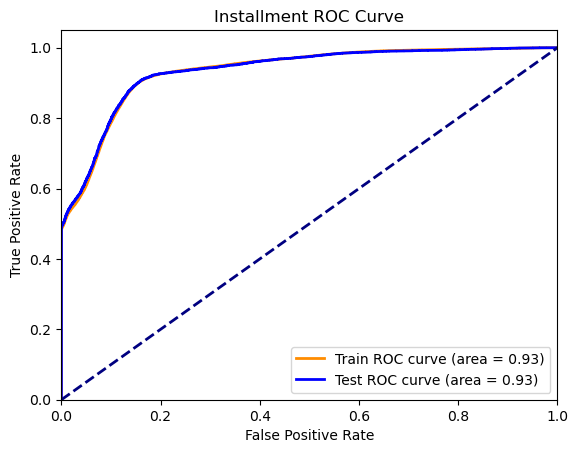

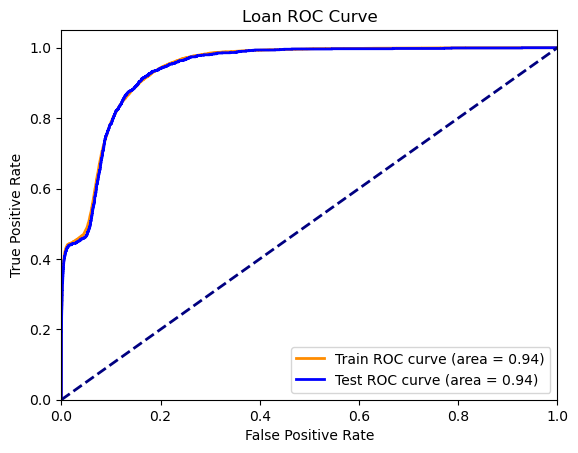

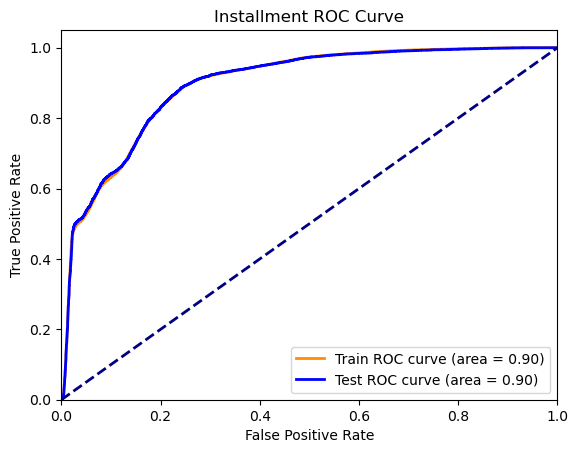

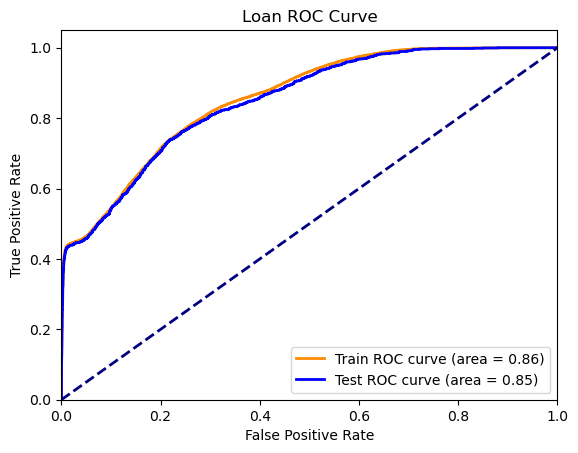

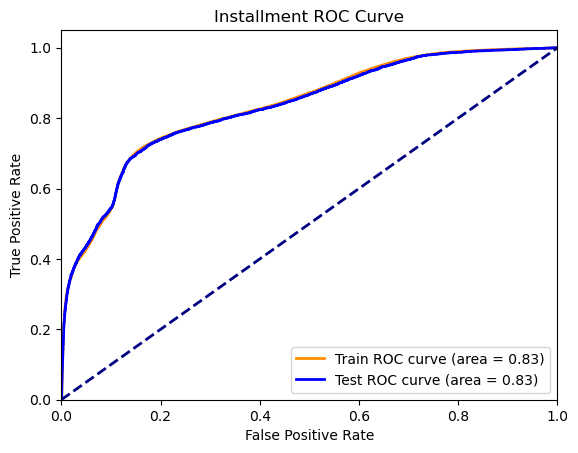

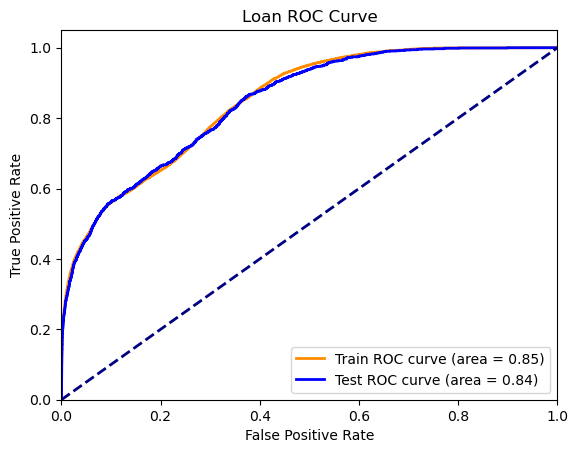

In [13]:
import random
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence 
from argparse import ArgumentParser
from collections import Counter
from quantization_uncertainty_exploration import *
# from doubledueling_dqn import *
import pdb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc


def calculate_metrics(predicted, actual):
    TP = np.sum((predicted == 1) & (actual == 1))
    FP = np.sum((predicted == 1) & (actual == 0))
    FN = np.sum((predicted == 0) & (actual == 1))

    accuracy = np.mean(predicted == actual)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

def plot_roc_curve(actual_labels_train, predicted_probs_train, actual_labels_test, predicted_probs_test, title_label, save_filename = None):
    fpr_train, tpr_train, _ = roc_curve(actual_labels_train, predicted_probs_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, _ = roc_curve(actual_labels_test, predicted_probs_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure()
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC Curve'.format(title_label))
    plt.legend(loc="lower right")
    
    if save_filename:
        plt.savefig(save_filename)
        print(f"ROC curve plot saved as {save_filename}")
    else:
        plt.show()

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_states_action = 21
varstate_size = 7

# Load training data
train_data = pd.read_csv('Simulator/simulator_train_data.csv')
train_input_data = train_data.values[:,1:n_states_action+1]
train_s = train_data.values[:,n_states_action+1: n_states_action+1+varstate_size]
train_installment = train_data.values[:,-3]
train_loan = train_data.values[:,-2]
train_r = train_data.values[:,-1]

# Load testing data
test_data = pd.read_csv('Simulator/simulator_test_data.csv')
test_input_data = test_data.values[:,1:n_states_action+1]
test_s = test_data.values[:,n_states_action+1: n_states_action+1+varstate_size]
test_installment = test_data.values[:,-3]
test_loan = test_data.values[:,-2]
test_r = test_data.values[:,-1]

for model in ['LSTM', 'RNN','GRU']:
    print('************************** Start {} *****************************'.format(model))

    sim_LR = 0.001
    sim_batch_size = 64
    simulator = torch.load('Simulator/generated_multitask_'+model+'_simulator_'+str(sim_LR)+'_'+str(sim_batch_size)+'.pkl')
    #simulator = torch.load('Simulator/generated_multitask_'+model+'_simulator.pkl')
    simulator.to(device)
    
    # Predictions for training data
    train_input_tensor = torch.tensor(train_input_data).float()
    train_input_tensor = Variable(torch.unsqueeze(train_input_tensor, 1))
    train_length = torch.ones(train_input_tensor.size(0), device = device).float()
    h_state = None

    simulator.eval()
    with torch.no_grad(): 
        train_pred_s, train_pred_installment, train_pred_loan, train_pred_r, h_state = simulator(train_input_tensor, train_length, h_state)
        train_pred_s = train_pred_s.detach().cpu().numpy().squeeze()
        mse_s = mean_squared_error(train_pred_s, train_s)
        train_pred_r = train_pred_r.detach().cpu().numpy().squeeze()
        mse_r = mean_squared_error(train_pred_r, train_r)
        train_pred_installment = train_pred_installment.detach().cpu().numpy().squeeze()
        auc_installment_train = roc_auc_score(train_installment, train_pred_installment)
        train_predicted = np.where(train_pred_installment > 0.5, 1, 0)
        acc_installment_train, precision_installment_train, recall_installment_train, f1_installment_train = calculate_metrics(train_predicted, train_installment)
        train_pred_loan = train_pred_loan.detach().cpu().numpy().squeeze()
        auc_loan_train = roc_auc_score(train_loan, train_pred_loan)
        train_predicted = np.where(train_pred_loan > 0.5, 1, 0)
        acc_loan_train, precision_loan_train, recall_loan_train, f1_loan_train = calculate_metrics(train_predicted, train_loan)

    print('Training state prediction mse ', mse_s)
    print('Training reward prediction mse ', mse_r)
    print('##################################################################')
    print('Training installment prediction auc ', auc_installment_train)
    print('Training installment prediction accuracy ', acc_installment_train)
    print('Training installment prediction precision ', precision_installment_train)
    print('Training installment prediction recall ', recall_installment_train)
    print('Training installment prediction f1 score ', f1_installment_train)
    print('##################################################################')
    print('Training loan prediction auc ', auc_loan_train)
    print('Training loan prediction accuracy ', acc_loan_train)
    print('Training loan prediction precision ', precision_loan_train)
    print('Training loan prediction recall ', recall_loan_train)
    print('Training loan prediction f1 score ', f1_loan_train)

    # Predictions for testing data
    test_input_tensor = torch.tensor(test_input_data).float()
    test_input_tensor = Variable(torch.unsqueeze(test_input_tensor, 1))
    test_length = torch.ones(test_input_tensor.size(0), device = device).float()
    h_state = None

    with torch.no_grad(): 
        test_pred_s, test_pred_installment, test_pred_loan, test_pred_r, h_state = simulator(test_input_tensor, test_length, h_state)
        test_pred_s = test_pred_s.detach().cpu().numpy().squeeze()
        mse_s_test = mean_squared_error(test_pred_s, test_s)
        test_pred_r = test_pred_r.detach().cpu().numpy().squeeze()
        mse_r_test = mean_squared_error(test_pred_r, test_r)
        test_pred_installment = test_pred_installment.detach().cpu().numpy().squeeze()
        auc_installment_test = roc_auc_score(test_installment, test_pred_installment)
        test_predicted = np.where(test_pred_installment > 0.5, 1, 0)
        acc_installment_test, precision_installment_test, recall_installment_test, f1_installment_test = calculate_metrics(test_predicted, test_installment)
        test_pred_loan = test_pred_loan.detach().cpu().numpy().squeeze()
        auc_loan_test = roc_auc_score(test_loan, test_pred_loan)
        test_predicted = np.where(test_pred_loan > 0.5, 1, 0)
        acc_loan_test, precision_loan_test, recall_loan_test, f1_loan_test = calculate_metrics(test_predicted, test_loan)

    print('Testing state prediction mse ', mse_s_test)
    print('Testing reward prediction mse ', mse_r_test)
    print('##################################################################')
    print('Testing installment prediction auc ', auc_installment_test)
    print('Testing installment prediction accuracy ', acc_installment_test)
    print('Testing installment prediction precision ', precision_installment_test)
    print('Testing installment prediction recall ', recall_installment_test)
    print('Testing installment prediction f1 score ', f1_installment_test)
    print('##################################################################')
    print('Testing loan prediction auc ', auc_loan_test)
    print('Testing loan prediction accuracy ', acc_loan_test)
    print('Testing loan prediction precision ', precision_loan_test)
    print('Testing loan prediction recall ', recall_loan_test)
    print('Testing loan prediction f1 score ', f1_loan_test)

    plot_roc_curve(train_installment, train_pred_installment, test_installment, test_pred_installment, 'Installment', save_filename='Simulator/Figure/CV' + model+'_ROC_installment.png')
    plot_roc_curve(train_loan, train_pred_loan, test_loan, test_pred_loan, 'Loan', save_filename='Simulator/Figure/CV' + model+'_ROC_loan.png')
